In [9]:
import os
import os
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from urllib.parse import urlparse
import joblib
import itertools
from xgboost import XGBClassifier, XGBRFClassifier

import matplotlib.pyplot as plt
import os
from sklearn.model_selection import *
from xgboost import XGBClassifier
from sklearn.metrics import *
import lightgbm as lgb
from sklearn.preprocessing import *
import seaborn as sns
from sklearn.utils import class_weight
from sklearn.ensemble import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif
import numpy as np

In [2]:
os.chdir('..')

In [3]:
df=pd.read_csv('artifacts/data_transformation/train.csv')

In [4]:
df.head()

,ACC_NO,MIN_DUE_AMT_1,MIN_DUE_AMT_2,MIN_DUE_AMT_3,MIN_DUE_AMT_4,MIN_DUE_AMT_5,MIN_DUE_AMT_6,OVER_LIMIT_FEE_1,OVER_LIMIT_FEE_2,OVER_LIMIT_FEE_3,...,NATURE_OF_BUS_DESC_PHARMACEUTICALS,NATURE_OF_BUS_DESC_PLANTATIONS,NATURE_OF_BUS_DESC_PROFESSIONAL SERVICES,NATURE_OF_BUS_DESC_PUBLIC UTILITY,NATURE_OF_BUS_DESC_PUBLICITY,NATURE_OF_BUS_DESC_SHARE BROKING,NATURE_OF_BUS_DESC_TELECOMMUNICATIONS,NATURE_OF_BUS_DESC_TRADING,NATURE_OF_BUS_DESC_TRAVEL,NATURE_OF_BUS_DESC_TRAVEL/AIRLINE
0,93944.0,542.70,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,7238.0,7798.39,4076.19,2045.47,1551.43,7527.77,887.62,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,11226.0,0.00,0.00,0.00,0.00,0.00,250.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,94712.0,818.80,650.04,579.68,830.91,577.58,636.81,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,119466.0,570.24,618.13,602.91,250.00,250.00,250.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df1=df.drop(columns=['ACC_NO'])

In [6]:
x=df1.drop(columns=['3_MONTH_NPL_STATUS'])
y=df1.loc[:,['3_MONTH_NPL_STATUS']]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,stratify=y,shuffle=True)

In [10]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(y_train),
                                                 y=y_train.values.reshape(-1))
class_weights_dict={0:class_weights[0],1:class_weights[1]}

In [78]:
#Initializing the XGB model
model=XGBClassifier(
    scale_pos_weight=200,
    max_depth=3,
    min_child_weight=3,
    subsample=0.65,
    colsample_bytree=0.9,
    objective='binary:logistic',
    eta=0.005,
    gamma=0.1,
    n_estimators=1000 ,
     enable_categorical=True,
     eval_metric='auc',
    alpha=0.05
 )


#Fitting the model
model.fit(X_train,y_train)

#Getting the probability and adjusting the threshold
y_pred_proba=model.predict_proba(X_test)[:,1]
y_pred_binary = (y_pred_proba >= 0.7).astype(int)

In [79]:
y_pred_proba=model.predict_proba(X_test)[:,1]

In [74]:
y_pred_binary = (y_pred_proba >= 0.7).astype(int)

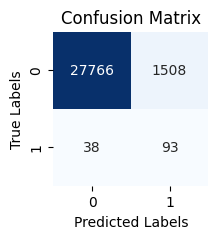

In [82]:

# NORMAL PARAMS & 0.7 THRESHOLD

conf_matrix_xgb = confusion_matrix(y_test,y_pred_binary)
plt.figure(figsize=(2, 2))
sns.heatmap(conf_matrix_xgb, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [86]:
print('AUC: {:.2f}%'.format(roc_auc_score(y_test, y_pred_binary) * 100))
print('F1: {:.2f}%'.format(f1_score(y_test, y_pred_binary) * 100))
print('Precision: {:.2f}%'.format(precision_score(y_test, y_pred_binary) * 100))
print('Recall: {:.2f}%'.format(recall_score(y_test, y_pred_binary) * 100))
print('Accuracy: {:.2f}%'.format(accuracy_score(y_test, y_pred_binary) * 100))

AUC: 82.92%
F1: 10.74%
Precision: 5.81%
Recall: 70.99%
Accuracy: 94.74%


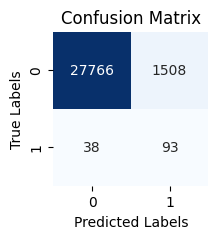

In [81]:
# MLFLOW PARAMS & 0.7 THRESHOLD

conf_matrix_xgb = confusion_matrix(y_test,y_pred_binary)
plt.figure(figsize=(2, 2))
sns.heatmap(conf_matrix_xgb, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

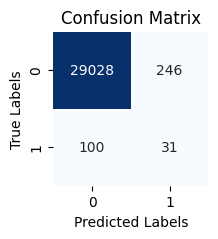

In [28]:
# MLFLOW PARAMS & 0.5 THRESHOLD

conf_matrix_xgb = confusion_matrix(y_test,y_pred_binary)
plt.figure(figsize=(2, 2))
sns.heatmap(conf_matrix_xgb, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

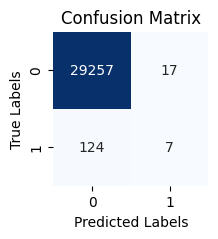

In [44]:
# MLFLOW PARAMS & 0.5 THRESHOLD

conf_matrix_xgb = confusion_matrix(y_test,y_pred_binary)
plt.figure(figsize=(2, 2))
sns.heatmap(conf_matrix_xgb, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [61]:
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [72]:
cost_matrix = np.array([[0, 1], [10, 0]])  # [TN, FP], [FN, TP]

# Cost-sensitive AdaBoost using EasyEnsemble
cost_sensitive_adaboost = EasyEnsembleClassifier(
    estimator=AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=3),
        n_estimators=50,
        algorithm='SAMME',
        random_state=42
    ),
    n_estimators=10,
    random_state=42
)

# Train the model
cost_sensitive_adaboost.fit(X_train, y_train)

# Make predictions
y_pred_ada = cost_sensitive_adaboost.predict(X_test)

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_bagging.py:888: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


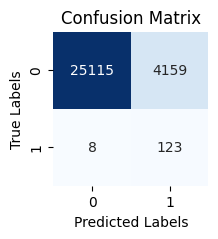

In [73]:

# NORMAL PARAMS & 0.7 THRESHOLD

conf_matrix_xgb = confusion_matrix(y_test,y_pred_ada)
plt.figure(figsize=(2, 2))
sns.heatmap(conf_matrix_xgb, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()